# Submission details
*   **Name**: Aditya Verma
*  **Student ID**: 12948511
*   **Task**: Assignment 2
*   **Subject**: 42028 Deep Learning and Convolutional Neural Network - Autumn 2020
*   **DataSet**: Fruits 360 (https://www.kaggle.com/moltean/fruits)
*   **CNN Used**: Finetuned ResNet50




Drive Mount

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Imports

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # for file editing
import shutil # for console commands

from PIL import Image # for opening images
import random # for selecting random images

#Data Preperation

##Directory
Changing to the working directory to access dataset

In [0]:
%cd /content/drive/My Drive/Assign_2/image-classification-finetune

/content/drive/My Drive/Assign_2/image-classification-finetune


##Dataset Download
This will download the dataset from the website provided

In [0]:
# only extract jpg files
def jpg_files(members):
    for tarinfo in members:
        if os.path.splitext(tarinfo.name)[1] == ".jpg":
            yield tarinfo

# extract function
def untar(fname,path="17flowers_dataset"): #untarring the archive
    tar = tarfile.open(fname)
    tar.extractall(path="17flowers_dataset", members=jpg_files(tar))
    tar.close()
    if path is "":
        print("File Extracted in Current Directory")
    else:
        print("File Extracted in to ",  path)

In [0]:
#function for downloading from URL 
import tarfile
import urllib

work_directory = "17flowers_dataset"
source_url = "http://www.robots.ox.ac.uk/~vgg/data/flowers/17/"
filename = "17flowers.tgz"
filepath = "17flowers_dataset"

if not os.path.exists(work_directory): #check if the folder exists; if not make dir
    os.mkdir(work_directory)
    print("Directory made")
filepath = os.path.join(work_directory, filename)

if not os.path.exists(filepath): # check if file exists; if not, download
    print("Downloading file, Please wait...")
    filepath, _ = urllib.request.urlretrieve(source_url + filename, # this is a function to download files
                                              filepath)
    statinfo = os.stat(filepath)
    print(('Succesfully downloaded', filename, statinfo.st_size, 'bytes.'))
    untar(filepath,work_directory)

In [0]:
os.listdir("17flowers_dataset/") #jpg folder should be available

##Dataset Visualisation

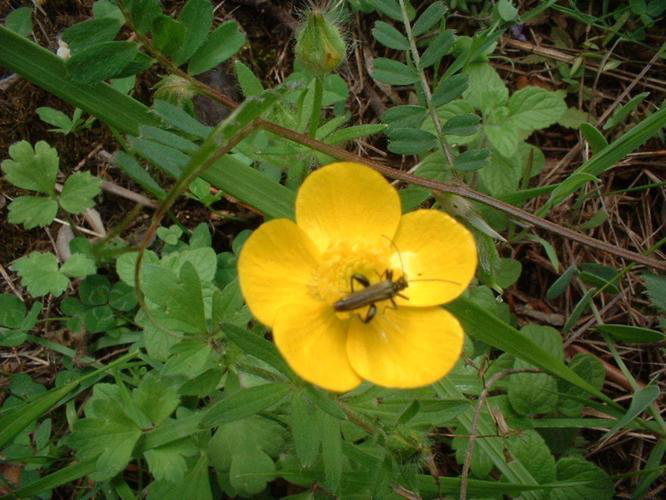

In [0]:
# will return one random image from the dataset for data visualisation
random_image = random.choice(os.listdir("17flowers_dataset/jpg/"))
Image.open("17flowers_dataset/jpg/"+random_image)

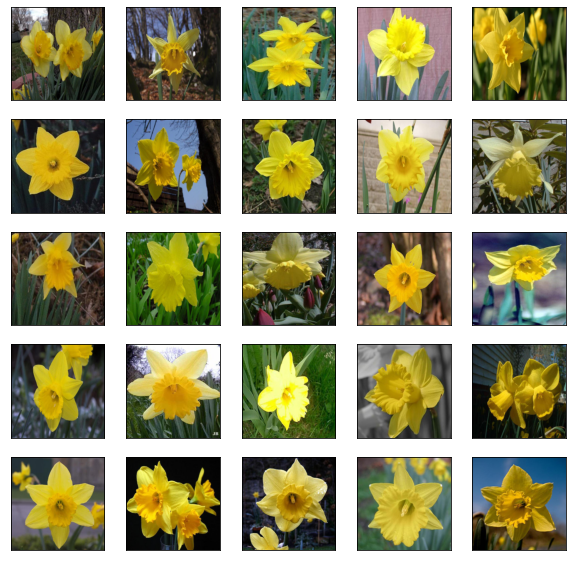

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10)) # plot 25 images
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i]/255, cmap=plt.cm.binary)

##Load all the Images
Expected: "1360"

In [3]:
#all images are loaded as np arrays
images=[]
labels=[]
total = 1361
count = 1

#load images as np arrays
def load_data(fpath):    
    img=Image.open(fpath).resize((224,224)) # resize to 224x224 for training purposes
    img = np.asarray(img, dtype='float32')
    return img

for i in range(1, total): 
    fname="17flowers_dataset/jpg/image_"    
    fpath = os.path.join(fname + str(i).zfill(4) + ".jpg")
    images.append(load_data(fpath))
    labels.append(count) #labels are created as well
    if i%80==0: count += 1
    
print("Number of images", len(images))
print("Number of labels", len(labels))

Number of images 1360
Number of labels 1360


##Convert to numpy arrays
Expected: (1360, 224, 224, 3)

In [4]:
images = np.asarray(images) # all of the images are converted to np array of (1360,224,224,3)
labels = np.asarray(labels).reshape(1360,1) # labels are also converted to (1360,1)
images.shape

(1360, 224, 224, 3)

##Splitting Images into training and test images

In [0]:
# split data into training and test
from sklearn.model_selection import train_test_split 
train_images, test_images, train_labels, test_labels = train_test_split(images, 
                                                                        labels, train_size = 0.8, 
                                                                        random_state =  104)

###Train images folder split

In [0]:
# dividing images into train and test folders by creating images from arrays
import cv2
import numpy as np

train_folder = 'train'
train_data = train_images

if not os.path.exists(train_folder): #check if the folder exists; if not make dir
  os.mkdir(train_folder)
n=0

for i in train_data:
  label_n = train_labels[n][0]
  train_subfolder = train_folder + "/" + str(label_n) 
  if not os.path.exists(train_subfolder): # create subfolders with categories
      os.mkdir(train_subfolder)
      i =+ 1
  train_filepath =  train_subfolder + "/" + str(n)+ ".jpg"
  cv2.imwrite(train_filepath, train_data[n]) #save image to corresponding subfolders
  n+=1
  
print("images saved to subfolder")


images saved to subfolder


###Test images folder split

In [0]:
test_folder = 'test'
test_data = test_images

if not os.path.exists(test_folder): #check if the folder exists; if not make dir
  os.mkdir(test_folder)
n=0

for i in test_data:
  label_n = train_labels[n][0]
  test_subfolder = test_folder + "/" + str(label_n) 
  if not os.path.exists(test_subfolder): # create subfolders with categories
      os.mkdir(test_subfolder)
      i =+ 1
      if (i == 16):
        print("subfoldermade")
  test_filepath =  test_subfolder + "/" + str(n)+ ".jpg"
  cv2.imwrite(test_filepath, test_data[n]) #save image to corresponding subfolders
  n+=1
print("images saved to test_subfolder")


images saved to test_subfolder


In [0]:
train_dir =os.path.realpath('train')
validation_dir = os.path.realpath('test')
#image_size = 224

#Model

##Imports

In [0]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
import matplotlib.pyplot as plt

import os
import tensorflow as tf
import zipfile
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.preprocessing import LabelBinarizer

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.optimizers import SGD
from keras.datasets import cifar10
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


##Importing Resnet which has been trained on imagenet

In [0]:
# Load ResNet50 Trained on imagenet
conv_base = ResNet50(weights="imagenet",include_top=False, input_shape=(224, 224, 3))

from keras import models
from keras import layers
from keras import optimizers

# Load the CONV layers of ResNet50 model and add the FC layers

model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(17, activation='sigmoid'))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
conv_base.summary()
for layer in conv_base.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in conv_base.layers:
    print(layer, layer.trainable)

#Data Augmentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen  = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=100,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical',
        shuffle=False)

Found 1088 images belonging to 17 classes.
Found 272 images belonging to 17 classes.


In [0]:
#checkpoint = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=1, period=3)
filepath='/tmp/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)


##Compiling the model

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-4),
              metrics=['accuracy'])

In [0]:
!python -c 'import tensorflow as tf; print(tf.__version__)'

2020-05-20 14:21:09.876186: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2.2.0


In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=1,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      callbacks = [checkpoint], #Displays the progress bar      
      verbose=2)


Epoch 1/1
 - 305s - loss: 1.3687 - accuracy: 0.9043 - val_loss: 0.5801 - val_accuracy: 0.8899


#Fine Tuning the model

In [0]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
layers = [(layer, layer.name, layer.trainable) for layer in conv_base.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_8,False
1,<keras.layers.convolutional.ZeroPadding2D obje...,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0...,conv1,False
3,<keras.layers.normalization.BatchNormalization...,bn_conv1,False
4,<keras.layers.core.Activation object at 0x7ff5...,activation_344,False
...,...,...,...
170,<keras.layers.core.Activation object at 0x7ff5...,activation_391,True
171,<keras.layers.convolutional.Conv2D object at 0...,res5c_branch2c,True
172,<keras.layers.normalization.BatchNormalization...,bn5c_branch2c,True
173,<keras.layers.merge.Add object at 0x7ff517d0b278>,add_128,True


In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model_finetuned = Sequential()
model_finetuned.add(conv_base)
model_finetuned.add(Dense(1024, activation='relu', input_dim=input_shape))
model_finetuned.add(Dropout(0.5))
model_finetuned.add(Dense(17, activation='sigmoid'))


model_finetuned.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-4),
              metrics=['accuracy'])

model_finetuned.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dense_41 (Dense)             (None, 7, 7, 1024)        2098176   
_________________________________________________________________
dropout_26 (Dropout)         (None, 7, 7, 1024)        0         
_________________________________________________________________
dense_42 (Dense)             (None, 7, 7, 17)          17425     
Total params: 25,703,313
Trainable params: 5,531,153
Non-trainable params: 20,172,160
_________________________________________________________________


In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape=(224, 224, 3)

model_finetuned = Sequential()
model_finetuned.add(conv_base)
model_finetuned.add(Dense(1024, activation='relu', input_dim = input_shape))
model_finetuned.add(Dropout(0.5))
model_finetuned.add(Dense(1024, activation='relu'))
model_finetuned.add(Dropout(0.5))
model_finetuned.add(Dense(17, activation='sigmoid'))

model_finetuned.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

model_finetuned.summary()



Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
dense_43 (Dense)             (None, 7, 7, 1024)        2098176   
_________________________________________________________________
dropout_27 (Dropout)         (None, 7, 7, 1024)        0         
_________________________________________________________________
dense_44 (Dense)             (None, 7, 7, 1024)        1049600   
_________________________________________________________________
dropout_28 (Dropout)         (None, 7, 7, 1024)        0         
_________________________________________________________________
dense_45 (Dense)             (None, 7, 7, 17)          17425     
Total params: 26,752,913
Trainable params: 6,580,753
Non-trainable params: 20,172,160
_________________________________

In [0]:
history_1 = model_finetuned.fit_generator(train_generator, 
                                  steps_per_epoch=train_generator.samples/train_generator.batch_size,
                                  epochs=2,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
                                  verbose=1)



Epoch 1/2


ValueError: ignored

#Results

In [0]:
!python3 -c 'import tensorflow as tf; print(tf.__version__)'
print('training acc.:',history.history['acc'][-1],'\n','test acc.:', (history.history['val_acc'])[-1])

2020-05-20 06:00:36.938171: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2.2.0
training acc.: 0.99621546 
 test acc.: 0.9409599304199219


#Plotting the graph

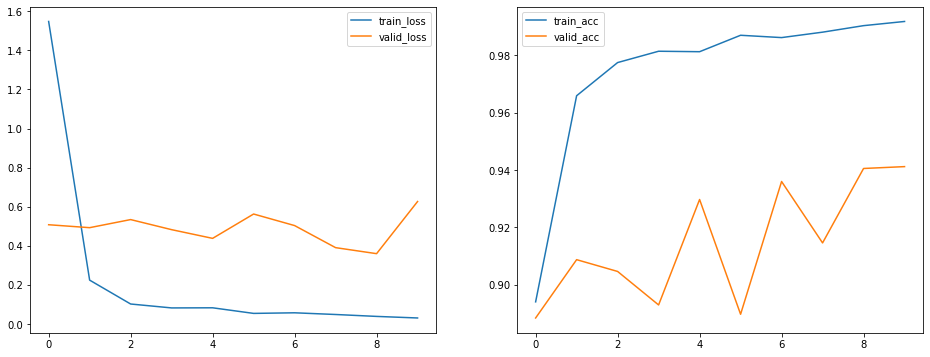

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[16,6])
ax1.plot(history.history['loss'], label='train_loss')
ax1.plot(history.history['val_loss'], label='valid_loss')
ax1.legend()
ax2.plot(history.history['acc'], label='train_acc')
ax2.plot(history.history['val_acc'], label='valid_acc')
ax2.legend();

#Install Tensorboard to visualise progress of training process

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip

--2020-05-14 04:31:48--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.175.20.97, 52.203.131.51, 50.16.94.112, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.175.20.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  42.9MB/s    in 0.3s    

2020-05-14 04:31:49 (42.9 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = train_dir
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')


###Get Tensorboard link

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://d0be2b6b.ngrok.io


#Result Visualisation

In [0]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[16,6])
ax1.plot(hist.history['loss'], label='train_loss')
ax1.plot(hist.history['val_loss'], label='valid_loss')
ax1.legend()
ax2.plot(hist.history['acc'], label='train_acc')
ax2.plot(hist.history['val_acc'], label='valid_acc')
ax2.legend();